In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

35640


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 217


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm65_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': True,
 'flip_vertical': False,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [5]:
for _fov_id, _fov_name in enumerate(fovs):
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_fov_id}.npy')
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[750,488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], diameter=30, min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    labels3d = np.array([cv2.resize(_ly, _cls.im_750.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(labels3d.shape, _fov_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], labels3d, )
    

## Check result

<IPython.core.display.Javascript object>


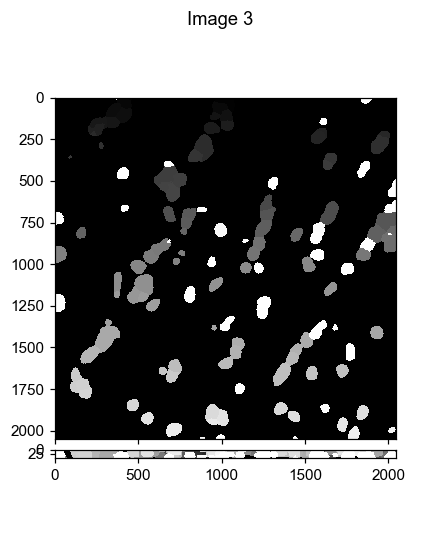

In [9]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, _cls.im_750, labels3d])

## Watershed

In [6]:
print(segmentation_save_folder)

\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation


In [7]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed


In [11]:
for _fov_id, _fov_name in enumerate(fovs):
    
    _save_id = _fov_id
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        continue
    
    print(f"- load seg file: {seg_save_file}")
    corr_labels3d = np.load(seg_save_file).astype(np.int16)
    # load DAPI/polyT
    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    # Prepare watershed
    waterIm, waterMask = watershed.prepare_watershed_images(polyt_im, 1.5)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )


- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_1.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_001.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.719s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.227s.
-- corrected illumination for channel 405 in 8.297s.
- Finished illumination correction in 16.750s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromati

- Loaded images for channels:['750', '488'] in 0.859s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.544s.
-- corrected illumination for channel 488 in 2.612s.
- Finished illumination correction in 5.386s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 0.03 -3.35  4.5 ] in 1.016s.
-- drift 1: [ 0.06 -3.38  4.35] in 0.942s.
-- drift 2: [ 0.04 -3.53  4.64] in 0.921s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.04333333 -3.42        4.49666667] for channel: 750
-- finish warpping channel 750 in 23.622s.
488 False True
-- warp image with drift:[ 0.04333333 -3.42        4.49666667] for channel: 488
-- fi

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_8.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_008.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_008.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_008.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.516s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.516s.
-- corrected illumination for channel 405 in 8.375s.
- Finished illumination correction in 17.999s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromati

- Loaded images for channels:['750', '488'] in 1.095s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.560s.
-- corrected illumination for channel 488 in 2.515s.
- Finished illumination correction in 5.266s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.03 -3.62  4.92] in 0.937s.
-- drift 1: [-0.02 -3.45  4.85] in 1.000s.
-- drift 2: [-0.03 -3.55  5.  ] in 0.891s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.02666667 -3.54        4.92333333] for channel: 750
-- finish warpping channel 750 in 23.578s.
488 False True
-- warp image with drift:[-0.02666667 -3.54        4.92333333] for channel: 488
-- fi

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_15.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_015.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_015.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_015.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 6.406s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.453s.
-- corrected illumination for channel 405 in 8.859s.
- Finished illumination correction in 18.750s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromat

- Loaded images for channels:['750', '488'] in 1.187s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.123s.
-- corrected illumination for channel 488 in 2.141s.
- Finished illumination correction in 4.547s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -3.45  3.53] in 0.858s.
-- drift 1: [ 0.02 -3.51  3.59] in 0.922s.
-- drift 2: [ 0.01 -3.59  3.59] in 0.875s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00666667 -3.51666667  3.57      ] for channel: 750
-- finish warpping channel 750 in 23.094s.
488 False True
-- warp image with drift:[ 0.00666667 -3.51666667  3.57      ] for channel: 488
-- fi

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_22.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_022.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_022.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_022.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 4.594s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.500s.
-- corrected illumination for channel 405 in 8.610s.
- Finished illumination correction in 17.280s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromat

- Loaded images for channels:['750', '488'] in 1.781s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.078s.
-- corrected illumination for channel 488 in 2.109s.
- Finished illumination correction in 4.453s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -3.21  4.13] in 0.875s.
-- drift 1: [ 0.   -3.14  4.25] in 0.875s.
-- drift 2: [ 0.   -3.16  4.22] in 0.890s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-3.33333333e-03 -3.17000000e+00  4.20000000e+00] for channel: 750
-- finish warpping channel 750 in 23.031s.
488 False True
-- warp image with drift:[-3.33333333e-03 -3.17000000e+00  4.20000000e+00

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_29.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_029.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_029.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_029.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.026s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.422s.
-- corrected illumination for channel 405 in 8.484s.
- Finished illumination correction in 18.031s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromat

- Loaded images for channels:['750', '488'] in 1.219s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.151s.
-- corrected illumination for channel 488 in 2.110s.
- Finished illumination correction in 4.500s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   -3.99  4.54] in 0.891s.
-- drift 1: [ 0.02 -4.04  4.53] in 0.892s.
-- drift 2: [ 0.02 -4.    4.48] in 0.874s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01333333 -4.01        4.51666667] for channel: 750
-- finish warpping channel 750 in 23.078s.
488 False True
-- warp image with drift:[ 0.01333333 -4.01        4.51666667] for channel: 488
-- fi

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_36.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_036.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_036.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_036.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 6.345s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.094s.
-- corrected illumination for channel 405 in 8.438s.
- Finished illumination correction in 16.750s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromat

- Loaded images for channels:['750', '488'] in 1.984s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.126s.
-- corrected illumination for channel 488 in 2.077s.
- Finished illumination correction in 4.578s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   -3.43  2.76] in 0.891s.
-- drift 1: [ 0.01 -3.43  2.72] in 0.875s.
-- drift 2: [ 0.01 -3.36  2.73] in 0.890s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00666667 -3.40666667  2.73666667] for channel: 750
-- finish warpping channel 750 in 23.031s.
488 False True
-- warp image with drift:[ 0.00666667 -3.40666667  2.73666667] for channel: 488
-- fi

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_43.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_043.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_043.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_043.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 7.996s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.386s.
-- corrected illumination for channel 405 in 8.829s.
- Finished illumination correction in 17.626s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromat

- Loaded images for channels:['750', '488'] in 1.953s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.062s.
-- corrected illumination for channel 488 in 2.094s.
- Finished illumination correction in 4.547s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -3.27  4.17] in 0.875s.
-- drift 1: [ 0.   -3.22  4.19] in 0.860s.
-- drift 2: [ 0.   -3.21  4.17] in 0.890s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-3.33333333e-03 -3.23333333e+00  4.17666667e+00] for channel: 750
-- finish warpping channel 750 in 22.984s.
488 False True
-- warp image with drift:[-3.33333333e-03 -3.23333333e+00  4.17666667e+00

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_50.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_050.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_050.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_050.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 6.375s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.312s.
-- corrected illumination for channel 405 in 8.172s.
- Finished illumination correction in 16.937s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromat

	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.094s.
-- corrected illumination for channel 488 in 2.156s.
- Finished illumination correction in 4.594s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01 -3.33  3.61] in 0.859s.
-- drift 1: [ 0.01 -3.19  3.59] in 0.875s.
-- drift 2: [-0.01 -2.98  3.55] in 0.891s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -3.16666667e+00  3.58333333e+00] for channel: 750
-- finish warpping channel 750 in 23.016s.
488 False True
-- warp image with drift:[ 3.33333333e-03 -3.16666667e+00  3.58333333e+00] for channel: 488
-- finish warpping channel 488 in 23.265s.
-- finish warpping in 46.281s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label

\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_057.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_057.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_057.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.641s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.406s.
-- corrected illumination for channel 405 in 8.609s.
- Finished illumination correction in 18.141s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_057.dax
-- all used channels: ['750', '647', '488']
-- single

-- corrected illumination for channel 750 in 2.156s.
-- corrected illumination for channel 488 in 2.172s.
- Finished illumination correction in 4.500s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.03 -4.64  3.15] in 0.906s.
-- drift 1: [-0.03 -4.54  3.08] in 0.891s.
-- drift 2: [-0.03 -4.65  3.18] in 0.890s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.03       -4.61        3.13666667] for channel: 750
-- finish warpping channel 750 in 23.109s.
488 False True
-- warp image with drift:[-0.03       -4.61        3.13666667] for channel: 488
-- finish warpping channel 488 in 23.234s.
-- finish warpping in 46.344s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_60.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brai

- Loaded images for channels:['488', '405'] in 7.735s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.344s.
-- corrected illumination for channel 405 in 8.516s.
- Finished illumination correction in 17.141s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_064.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.969s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.062s.
-- corrected illumination for channel 488 in 2.079s.

-- drift 0: [-0.02 -2.79  2.73] in 0.890s.
-- drift 1: [ 0.   -2.8   2.85] in 0.875s.
-- drift 2: [-0.01 -2.74  2.76] in 0.891s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01       -2.77666667  2.78      ] for channel: 750
-- finish warpping channel 750 in 22.922s.
488 False True
-- warp image with drift:[-0.01       -2.77666667  2.78      ] for channel: 488
-- finish warpping channel 488 in 23.281s.
-- finish warpping in 46.203s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_67.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_68.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_068.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_068.dax
Initialize 

- Loaded images for channels:['488', '405'] in 5.094s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.781s.
-- corrected illumination for channel 405 in 8.203s.
- Finished illumination correction in 17.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_071.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.467s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.047s.
-- corrected illumination for channel 488 in 2.094s.

-- drift 0: [-0.01 -3.17  3.36] in 0.974s.
-- drift 1: [ 0.   -3.11  3.38] in 0.886s.
-- drift 2: [ 0.01 -3.28  3.45] in 0.875s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.         -3.18666667  3.39666667] for channel: 750
-- finish warpping channel 750 in 22.937s.
488 False True
-- warp image with drift:[ 0.         -3.18666667  3.39666667] for channel: 488
-- finish warpping channel 488 in 23.391s.
-- finish warpping in 46.328s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_74.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_75.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_075.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_075.dax
Initialize 

- Loaded images for channels:['488', '405'] in 4.937s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.109s.
-- corrected illumination for channel 405 in 8.531s.
- Finished illumination correction in 16.828s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_078.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.818s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.073s.
-- corrected illumination for channel 488 in 2.109s.

-- drift 0: [-0.01 -3.22  3.75] in 1.250s.
-- drift 1: [ 0.01 -3.12  3.77] in 1.031s.
-- drift 2: [ 0.   -3.18  3.84] in 0.969s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.         -3.17333333  3.78666667] for channel: 750
-- finish warpping channel 750 in 23.734s.
488 False True
-- warp image with drift:[ 0.         -3.17333333  3.78666667] for channel: 488
-- finish warpping channel 488 in 23.297s.
-- finish warpping in 47.031s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_81.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_82.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_082.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_082.dax
Initialize 

- Loaded images for channels:['488', '405'] in 5.141s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.281s.
-- corrected illumination for channel 405 in 8.203s.
- Finished illumination correction in 16.688s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_085.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.781s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.166s.
-- corrected illumination for channel 488 in 2.141s.

-- drift 0: [-0.02 -3.01  3.19] in 0.953s.
-- drift 1: [-0.01 -2.99  3.11] in 0.875s.
-- drift 2: [-0.01 -2.99  3.24] in 0.875s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01333333 -2.99666667  3.18      ] for channel: 750
-- finish warpping channel 750 in 23.578s.
488 False True
-- warp image with drift:[-0.01333333 -2.99666667  3.18      ] for channel: 488
-- finish warpping channel 488 in 23.766s.
-- finish warpping in 47.343s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_88.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_89.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_089.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_089.dax
Initialize 

- Loaded images for channels:['488', '405'] in 5.155s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.438s.
-- corrected illumination for channel 405 in 8.469s.
- Finished illumination correction in 18.047s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_092.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.906s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.557s.
-- corrected illumination for channel 488 in 2.516s.

-- drift 0: [-0.02 -3.15  3.46] in 0.891s.
-- drift 1: [ 0.   -3.12  3.45] in 0.969s.
-- drift 2: [-0.01 -3.12  3.48] in 0.922s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01       -3.13        3.46333333] for channel: 750
-- finish warpping channel 750 in 23.875s.
488 False True
-- warp image with drift:[-0.01       -3.13        3.46333333] for channel: 488
-- finish warpping channel 488 in 23.235s.
-- finish warpping in 47.110s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_95.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_96.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_096.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_096.dax
Initialize 

- Loaded images for channels:['488', '405'] in 5.313s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.280s.
-- corrected illumination for channel 405 in 8.344s.
- Finished illumination correction in 16.828s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_099.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.000s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.103s.
-- corrected illumination for channel 488 in 2.109s.

-- drift 0: [ 0.   -3.34  1.76] in 1.000s.
-- drift 1: [ 0.01 -3.3   1.8 ] in 1.094s.
-- drift 2: [ 0.   -2.87  1.37] in 1.047s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00333333 -3.17        1.64333333] for channel: 750
-- finish warpping channel 750 in 23.453s.
488 False True
-- warp image with drift:[ 0.00333333 -3.17        1.64333333] for channel: 488
-- finish warpping channel 488 in 23.469s.
-- finish warpping in 46.922s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_102.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_103.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_103.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_103.dax
Initializ

- Loaded images for channels:['488', '405'] in 5.485s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.547s.
-- corrected illumination for channel 405 in 9.094s.
- Finished illumination correction in 18.688s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_106.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.906s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.438s.
-- corrected illumination for channel 488 in 2.547s.

-- drift 0: [-0.03 -2.42  3.6 ] in 0.891s.
-- drift 1: [-0.02 -2.86  3.3 ] in 0.915s.
-- drift 2: [ 0.   -2.87  3.22] in 0.915s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01666667 -2.71666667  3.37333333] for channel: 750
-- finish warpping channel 750 in 22.936s.
488 False True
-- warp image with drift:[-0.01666667 -2.71666667  3.37333333] for channel: 488
-- finish warpping channel 488 in 23.383s.
-- finish warpping in 46.319s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_109.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_110.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_110.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_110.dax
Initializ

- Loaded images for channels:['488', '405'] in 4.844s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.843s.
-- corrected illumination for channel 405 in 8.172s.
- Finished illumination correction in 16.187s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_113.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.813s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.092s.
-- corrected illumination for channel 488 in 2.085s.

-- drift 0: [-0.01 -2.35  1.78] in 0.891s.
-- drift 1: [ 0.   -2.33  1.77] in 0.875s.
-- drift 2: [ 0.   -2.38  1.8 ] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.00333333 -2.35333333  1.78333333] for channel: 750
-- finish warpping channel 750 in 22.359s.
488 False True
-- warp image with drift:[-0.00333333 -2.35333333  1.78333333] for channel: 488
-- finish warpping channel 488 in 22.828s.
-- finish warpping in 45.188s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_116.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_117.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_117.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_117.dax
Initializ

- Loaded images for channels:['488', '405'] in 5.474s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.842s.
-- corrected illumination for channel 405 in 8.110s.
- Finished illumination correction in 16.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_120.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.689s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.000s.
-- corrected illumination for channel 488 in 2.047s.

-- drift 0: [-0.06 -2.95  3.89] in 0.844s.
-- drift 1: [-0.06 -2.94  3.92] in 0.891s.
-- drift 2: [-0.05 -2.94  3.97] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.05666667 -2.94333333  3.92666667] for channel: 750
-- finish warpping channel 750 in 22.594s.
488 False True
-- warp image with drift:[-0.05666667 -2.94333333  3.92666667] for channel: 488
-- finish warpping channel 488 in 23.141s.
-- finish warpping in 45.735s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_123.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_124.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_124.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_124.dax
Initializ

- Loaded images for channels:['488', '405'] in 5.531s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.124s.
-- corrected illumination for channel 405 in 8.750s.
- Finished illumination correction in 17.922s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_127.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.938s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.375s.
-- corrected illumination for channel 488 in 2.156s.

-- drift 0: [-0.02 -2.55  2.52] in 0.859s.
-- drift 1: [-0.01 -2.62  2.46] in 0.859s.
-- drift 2: [ 0.   -2.56  2.53] in 0.859s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01       -2.57666667  2.50333333] for channel: 750
-- finish warpping channel 750 in 22.281s.
488 False True
-- warp image with drift:[-0.01       -2.57666667  2.50333333] for channel: 488
-- finish warpping channel 488 in 22.469s.
-- finish warpping in 44.750s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_130.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_131.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_131.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_131.dax
Initializ

- Loaded images for channels:['488', '405'] in 4.395s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.094s.
-- corrected illumination for channel 405 in 8.281s.
- Finished illumination correction in 16.588s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_134.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.781s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.145s.
-- corrected illumination for channel 488 in 2.063s.

-- drift 0: [-0.01 -1.97  3.51] in 0.844s.
-- drift 1: [ 0.   -2.05  3.41] in 0.859s.
-- drift 2: [ 0.   -1.96  3.49] in 0.844s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-3.33333333e-03 -1.99333333e+00  3.47000000e+00] for channel: 750
-- finish warpping channel 750 in 22.156s.
488 False True
-- warp image with drift:[-3.33333333e-03 -1.99333333e+00  3.47000000e+00] for channel: 488
-- finish warpping channel 488 in 22.500s.
-- finish warpping in 44.656s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_137.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_138.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_138.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv

- Loaded images for channels:['488', '405'] in 4.734s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.031s.
-- corrected illumination for channel 405 in 8.000s.
- Finished illumination correction in 16.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_141.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.812s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.031s.
-- corrected illumination for channel 488 in 1.984s.

-- drift 0: [-0.01 -2.13  1.56] in 0.859s.
-- drift 1: [ 0.   -2.14  1.51] in 0.891s.
-- drift 2: [ 0.   -2.11  1.57] in 0.863s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.00333333 -2.12666667  1.54666667] for channel: 750
-- finish warpping channel 750 in 22.169s.
488 False True
-- warp image with drift:[-0.00333333 -2.12666667  1.54666667] for channel: 488
-- finish warpping channel 488 in 23.187s.
-- finish warpping in 45.356s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_144.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_145.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_145.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_145.dax
Initializ

- Loaded images for channels:['488', '405'] in 4.442s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.233s.
-- corrected illumination for channel 405 in 8.156s.
- Finished illumination correction in 18.281s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_148.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.421s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.047s.
-- corrected illumination for channel 488 in 2.062s.

-- drift 0: [-0.04 -2.15  1.93] in 1.078s.
-- drift 1: [-0.05 -2.11  2.02] in 1.031s.
-- drift 2: [-0.04 -2.12  1.98] in 1.007s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04333333 -2.12666667  1.97666667] for channel: 750
-- finish warpping channel 750 in 23.821s.
488 False True
-- warp image with drift:[-0.04333333 -2.12666667  1.97666667] for channel: 488
-- finish warpping channel 488 in 23.485s.
-- finish warpping in 47.305s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_151.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_152.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_152.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_152.dax
Initializ

- Loaded images for channels:['488', '405'] in 5.469s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 8.129s.
-- corrected illumination for channel 405 in 8.652s.
- Finished illumination correction in 17.047s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_155.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.531s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.141s.
-- corrected illumination for channel 488 in 2.203s.

-- drift 0: [-0.04 -2.23  2.76] in 0.891s.
-- drift 1: [-0.03 -2.23  2.96] in 0.922s.
-- drift 2: [-0.03 -2.27  2.99] in 0.922s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.03333333 -2.24333333  2.90333333] for channel: 750
-- finish warpping channel 750 in 23.016s.
488 False True
-- warp image with drift:[-0.03333333 -2.24333333  2.90333333] for channel: 488
-- finish warpping channel 488 in 22.625s.
-- finish warpping in 45.641s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_158.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_159.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_159.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_159.dax
Initializ

-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.485s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.984s.
-- corrected illumination for channel 405 in 8.093s.
- Finished illumination correction in 16.453s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_162.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.000s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.078s.
-- corrected 

-- drift 0: [ 0.01 -2.75  2.12] in 0.968s.
-- drift 1: [ 0.   -2.74  2.13] in 0.937s.
-- drift 2: [ 0.01 -2.74  2.1 ] in 0.969s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00666667 -2.74333333  2.11666667] for channel: 750
-- finish warpping channel 750 in 22.800s.
488 False True
-- warp image with drift:[ 0.00666667 -2.74333333  2.11666667] for channel: 488
-- finish warpping channel 488 in 22.872s.
-- finish warpping in 45.672s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_165.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_166.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_166.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_166.dax
Initializ

- Loaded images for channels:['488', '405'] in 6.609s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.781s.
-- corrected illumination for channel 405 in 8.000s.
- Finished illumination correction in 15.953s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_169.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.156s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.105s.
-- corrected illumination for channel 488 in 2.016s.

-- drift 0: [-0.04 -1.98  1.79] in 0.843s.
-- drift 1: [-0.05 -2.02  2.02] in 0.860s.
-- drift 2: [ 0.02 -1.91  1.38] in 0.859s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.02333333 -1.97        1.73      ] for channel: 750
-- finish warpping channel 750 in 22.234s.
488 False True
-- warp image with drift:[-0.02333333 -1.97        1.73      ] for channel: 488
-- finish warpping channel 488 in 22.469s.
-- finish warpping in 44.703s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_172.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_173.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_173.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_173.dax
Initializ

- Loaded images for channels:['488', '405'] in 6.094s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.906s.
-- corrected illumination for channel 405 in 8.125s.
- Finished illumination correction in 16.219s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_176.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.875s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.062s.
-- corrected illumination for channel 488 in 2.047s.

-- drift 1: [-0.06 -2.65  2.82] in 0.844s.
-- drift 2: [-0.04 -2.63  2.7 ] in 0.875s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04333333 -2.66        2.74333333] for channel: 750
-- finish warpping channel 750 in 22.219s.
488 False True
-- warp image with drift:[-0.04333333 -2.66        2.74333333] for channel: 488
-- finish warpping channel 488 in 22.547s.
-- finish warpping in 44.766s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_179.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_180.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_180.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_180.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chr

- Loaded images for channels:['488', '405'] in 5.750s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.969s.
-- corrected illumination for channel 405 in 8.062s.
- Finished illumination correction in 16.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_183.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.078s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.047s.
-- corrected illumination for channel 488 in 2.078s.

-- drift 0: [-0.02 -2.01  1.2 ] in 0.833s.
-- drift 1: [-0.03 -1.99  1.19] in 0.845s.
-- drift 2: [-0.01 -2.02  1.21] in 0.867s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.02       -2.00666667  1.2       ] for channel: 750
-- finish warpping channel 750 in 21.945s.
488 False True
-- warp image with drift:[-0.02       -2.00666667  1.2       ] for channel: 488
-- finish warpping channel 488 in 21.981s.
-- finish warpping in 43.926s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_186.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_187.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_187.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_187.dax
Initializ

- Loaded images for channels:['488', '405'] in 5.297s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.899s.
-- corrected illumination for channel 405 in 7.905s.
- Finished illumination correction in 15.972s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_190.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.887s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.030s.
-- corrected illumination for channel 488 in 2.063s.

-- drift 0: [-0.03 -2.32  3.03] in 0.832s.
-- drift 1: [-0.04 -2.32  3.04] in 0.834s.
-- drift 2: [-0.02 -2.23  3.08] in 0.833s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.03 -2.29  3.05] for channel: 750
-- finish warpping channel 750 in 22.065s.
488 False True
-- warp image with drift:[-0.03 -2.29  3.05] for channel: 488
-- finish warpping channel 488 in 22.126s.
-- finish warpping in 44.192s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_193.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_194.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_194.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_194.dax
Initialize DaxProcesser for file:\\10.245.74.

- Loaded images for channels:['488', '405'] in 4.661s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.794s.
-- corrected illumination for channel 405 in 8.127s.
- Finished illumination correction in 16.146s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_197.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.779s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.051s.
-- corrected illumination for channel 488 in 2.072s.

-- drift 0: [-0.01 -2.05  1.73] in 0.821s.
-- drift 1: [-0.02 -2.09  1.66] in 0.862s.
-- drift 2: [-0.01 -2.13  1.66] in 0.833s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01333333 -2.09        1.68333333] for channel: 750
-- finish warpping channel 750 in 22.227s.
488 False True
-- warp image with drift:[-0.01333333 -2.09        1.68333333] for channel: 488
-- finish warpping channel 488 in 22.550s.
-- finish warpping in 44.777s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_200.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_201.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_201.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_201.dax
Initializ

- Loaded images for channels:['488', '405'] in 4.753s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.914s.
-- corrected illumination for channel 405 in 8.085s.
- Finished illumination correction in 16.204s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_204.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.583s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.005s.
-- corrected illumination for channel 488 in 2.073s.

-- drift 0: [-0.03 -2.21  3.56] in 0.843s.
-- drift 1: [-0.03 -2.17  3.56] in 0.835s.
-- drift 2: [-0.02 -2.21  3.48] in 0.838s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.02666667 -2.19666667  3.53333333] for channel: 750
-- finish warpping channel 750 in 21.748s.
488 False True
-- warp image with drift:[-0.02666667 -2.19666667  3.53333333] for channel: 488
-- finish warpping channel 488 in 22.042s.
-- finish warpping in 43.791s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_207.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_208.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_208.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_208.dax
Initializ

- Loaded images for channels:['488', '405'] in 6.420s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.882s.
-- corrected illumination for channel 405 in 8.144s.
- Finished illumination correction in 16.235s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_211.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.794s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.044s.
-- corrected illumination for channel 488 in 2.025s.

-- drift 0: [-0.03 -2.15  2.78] in 0.849s.
-- drift 1: [-0.02 -2.04  2.75] in 0.841s.
-- drift 2: [-0.03 -2.15  2.69] in 0.860s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.02666667 -2.11333333  2.74      ] for channel: 750
-- finish warpping channel 750 in 22.094s.
488 False True
-- warp image with drift:[-0.02666667 -2.11333333  2.74      ] for channel: 488
-- finish warpping channel 488 in 22.105s.
-- finish warpping in 44.199s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_214.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_215.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_215.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_215.dax
Initializ

## Check result

<IPython.core.display.Javascript object>


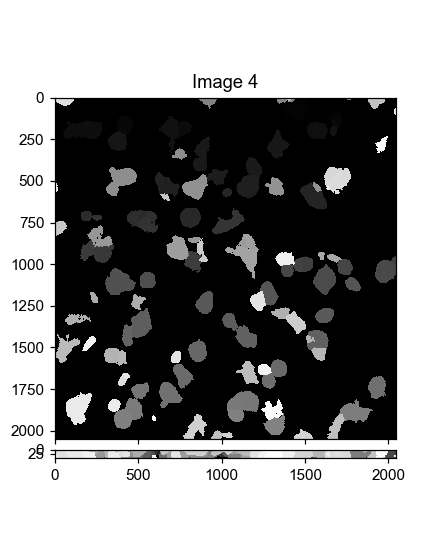

In [13]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, polyt_im, corr_labels3d, new_labels])